# OSGD - GAN Project - MNIST Fashion


## Contents
1. Setup
2. Loading The Data
3. Defining the GAN Class
4. Instantiating a GAN
5. Training and Testing

## 1. Setup

In [1]:
import torch
from torchvision import transforms, datasets
from torch import nn, optim
from torch.autograd.variable import Variable

import matplotlib.pyplot as plt
import numpy as np

## 2. Loading The Data

In [2]:
train_set = datasets.FashionMNIST(        # Gets the train_set from FashionMNIST
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

In [3]:
# Helper function to display images
def show_images(images_arry,num_images_to_show):
    # Imput: images_arry, an array of tensors to display as images; num_images_to_show, integer representing num images to show
    # Output: prints images as output
    
    n = np.min([len(images_arry),num_images_to_show]) # Number of images to display
    fig, ax = plt.subplots(1,n) # Makes an array of subplot objects 
    
    for index in range(n):
        ax[index].imshow(images_arry[index].squeeze(), cmap='gray_r'); # Investigate the cmap
        ax[index].axis('off')  # clear x-axis and y-axis
    plt.show()

We can use a train loader to batch our images. IMPORTANT: images are 1 x 28 x 28 tensors with vals in [0,1]

## 3. Defining the GAN Class

We use the GAN code from the previous notebook, but chainging the training function to only take in one minibatch. This then allows us to use the DATALOADER (in Pytorch) to efficiently load data in batches.

In [4]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self,ModuleList):
        # Input: a torch.nn.ModuleList object, specifying nn layers
        # Output: Instanciates a nn object with the correct layers and activiation functions
        
        super(NeuralNetwork,self).__init__()
        self.layers = ModuleList # Sets network layers
        
    def forward(self,x):
        # Input: a tensor x, with size that agrees with the network
        # Output: a tensor, the network evaluated on x
        
        for l in self.layers:
            x = l(x)
        return x

In [5]:
def ones_target(n):
    # Input: An integer n
    # Output: Tensor of 1's size nx1
    
    return Variable(torch.ones(n,1))
    
def zeros_target(n):
    # Input: An integer n
    # Output: Tensor of 0's size nx1
    
    return Variable(torch.zeros(n,1))

In [6]:
class GAN():
    def __init__(self,d_ModuleList,g_ModuleList,data_dim,latent_dim):
        # Input: d_ModuleList,g_ModuleList are torch.nn.ModuleLists, data_dim is a tuple, latent_dim is a tuple
        # Output: Instance of GAN class 
        
        # Instantiate the discriminator & generator
        self.discriminator = NeuralNetwork(d_ModuleList)
        self.generator = NeuralNetwork(g_ModuleList)
        
        self.data_dim = data_dim # Number of inputs into discriminator = dimention of data, as a tuple
        self.latent_dim = latent_dim # Number of inputs into generator = dimention of latent space
    
    def update_discriminator(self,real_data,generated_data):
        # Input: real_data (minibatch from real data set) ,generated_data (minibatch made by generator)
        # Output: discriminator's loss and mean predictions for real and generated data
        
        # Initial setup/clearing of gradients
        self.d_optimiser.zero_grad()
        loss = nn.BCELoss()
        N,M = real_data.size(0),generated_data.size(0) # Number of data items in each sample
        
        # Apply discriminator to data entered (in order real then fake)
        x = self.discriminator(torch.cat([real_data,generated_data]))
        
        # Create target labels (in order real then fake)
        y = torch.cat([ones_target(N),zeros_target(M)])
        
        # Calculate loss and backprop
        error = loss(x,y)
        error.backward()
        
        # Update discriminator network
        self.d_optimiser.step()
        
        # Return error and mean predictions
        return error.detach().numpy(), torch.mean(x[:N].detach()).numpy(),torch.mean(x[-M:].detach()).numpy()
        
    def update_generator(self,generated_data):
        # Input: generated_data (minibatch made by generator)
        # Output: generators' loss
        
        # Initial setup/clearing of gradients
        self.g_optimiser.zero_grad()
        loss = nn.BCELoss()
        M = generated_data.size(0)
        
        # Apply discriminator to data entered
        x = self.discriminator(generated_data)
        
        # Create target labels
        y = ones_target(M) # Want target to be 1's, opposite of disciminator's aim
        
        # Calculate loss and backprop
        error = loss(x,y)
        error.backward()
        
        # Update generator network
        self.g_optimiser.step()
        
        # Return error
        return error.detach().numpy() 
    
    def batch_train(self,data_batch,d_learning_rate,g_learning_rate):
        # Input: data_batch (in a tensor size 1 by n),d_learning_rate/g_learning_rate, learning rates for each nn
        # Output: returns progress info, updates discriminator and generator networks
        
        # Sets optimisers
        self.d_optimiser = optim.Adam(self.discriminator.parameters(), d_learning_rate)
        self.g_optimiser = optim.Adam(self.generator.parameters(), g_learning_rate)
        
        k = 1 # Number of steps to apply to the discriminator, In original paper this variable is assigned to 1
        n = data_batch.size(0) # Number of data items in  batch

        for i in range(k):
            # Reshape real data if needed
            data_batch = data_batch.reshape((n,)+self.data_dim)
            
            # Get batch of fake data from generator
            generated_data = self.generate(self.noise(n)).detach() # Same size as real_data, detatch so generator gradient not affected
            
            # Optimise discriminator
            d_error,avg_real_pred,avg_fake_pred = self.update_discriminator(data_batch,generated_data)
            
            
        # Optimise generator, with new batch of generated data
        generated_data = self.generate(self.noise(n)) # Need new data here as discriminator has been trained on the 'old' generated_data
        g_error = self.update_generator(generated_data)
        
        return g_error,d_error,avg_real_pred,avg_fake_pred
            
    def noise(self,n):
    # Input: An integer n, the number of samples to make
    # Output: A tensor of size nxdims of random values

        return Variable(torch.randn((n,)+self.latent_dim))
    
    def generate(self,noise):
        # Input: noise vector of length n
        # Output: n generated data items from the generator
        
        n = noise.size(0)
        return self.generator(noise).view((n,)+self.data_dim)

## 4. Instantiating a GAN

Below are two cells, one using a CNN, one using an linear nn. Just comment one out and turn the other one into code to swap back and forth.

In [7]:
fashion_GAN = GAN(nn.ModuleList([
                    nn.Sequential(                     # Module list for discriminator
                        nn.Linear(784, 1024),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3),
                        
                        nn.Linear(1024, 512),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3),

                        nn.Linear(512, 256),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3),
                        
                        torch.nn.Linear(256, 1),
                        torch.nn.Sigmoid()
                    )]),
                  nn.ModuleList([                      # Module list for generator
                    nn.Sequential(
                        nn.Linear(100,256),
                        nn.LeakyReLU(0.2),

                        nn.Linear(256,512),
                        nn.LeakyReLU(0.2),

                        nn.Linear(512,1024),
                        nn.LeakyReLU(0.2),

                        nn.Linear(1024,784),
                        torch.nn.Tanh()
                    )]),
                  (784,),                              # Tuple representing data dim into discriminator
                  (100,))                              # Tuple representing latent dim into generator

fashion_GAN = GAN(nn.ModuleList([                      # Module list for discriminator
                    nn.Sequential(
                        nn.Conv2d(1, 128, kernel_size=3, padding=0),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        
                        nn.Conv2d(128, 128, kernel_size=3, padding=0),
                        nn.ReLU(),
                        
                        nn.Flatten(),
                        
                        nn.Linear(128*11*11,1),
                        torch.nn.Sigmoid()
                    )]),
                  nn.ModuleList([                      # Module list for generator
                    nn.Sequential(
                        nn.Linear(100,256),
                        nn.LeakyReLU(0.1),
                        nn.Dropout(0.3),

                        nn.Linear(256,512),
                        nn.LeakyReLU(0.1),
                        nn.Dropout(0.3),

                        nn.Linear(512,1024),
                        nn.LeakyReLU(0.1),

                        nn.Linear(1024,784),
                        torch.nn.Sigmoid()
                    )]),
                  (1,28,28),                           # Tuple representing data dim into discriminator
                  (100,))                              # Tuple representing latent dim into generator

In [8]:
data_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)

## 5. Training and Testing

In [9]:
def save_images(n,path,filename,noise_vec):
    #Input: n, an integer number of pictures; path, filepath; filename,name of file, can be an int or str for example; voise_vec, a vector or noise used to generate images
    #Output: Saves an image with the desired name in the desired location

    images_arry = (fashion_GAN.generate(noise_vec).detach()).view(n,1,28,28)
    fig, ax = plt.subplots(1,n) # Makes an array of subplot objects 
    
    for index in range(n):
        ax[index].imshow(images_arry[index].squeeze(), cmap='gray_r'); # Investigate the cmap
        ax[index].axis('off')  # clear x-axis and y-axis
        
    plt.savefig(path+"{0}.png".format(filename),bbox_inches='tight')
    plt.close(fig)

EPOCH: [1:40]   BATCH: [0:600]
	 G Loss = 0.68	 D Loss = 0.7
	 D(Real) = 0.5	 D(Fake) = 0.51


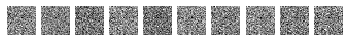

EPOCH: [1:40]   BATCH: [100:600]
	 G Loss = 2.44	 D Loss = 0.13
	 D(Real) = 0.98	 D(Fake) = 0.21


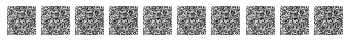

EPOCH: [1:40]   BATCH: [200:600]
	 G Loss = 14.56	 D Loss = 0.85
	 D(Real) = 0.96	 D(Fake) = 0.5


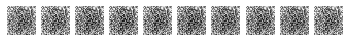

EPOCH: [1:40]   BATCH: [300:600]
	 G Loss = 12.98	 D Loss = 1.53
	 D(Real) = 0.89	 D(Fake) = 0.76


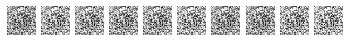

EPOCH: [1:40]   BATCH: [400:600]
	 G Loss = 3.48	 D Loss = 1.57
	 D(Real) = 0.96	 D(Fake) = 0.93


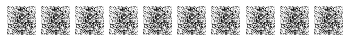

EPOCH: [1:40]   BATCH: [500:600]
	 G Loss = 3.47	 D Loss = 0.64
	 D(Real) = 0.97	 D(Fake) = 0.67


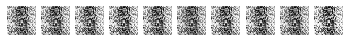

EPOCH: [2:40]   BATCH: [0:600]
	 G Loss = 3.95	 D Loss = 0.52
	 D(Real) = 0.78	 D(Fake) = 0.32


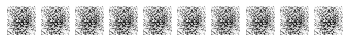

EPOCH: [2:40]   BATCH: [100:600]
	 G Loss = 1.01	 D Loss = 0.61
	 D(Real) = 0.71	 D(Fake) = 0.29


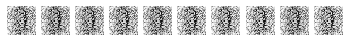

EPOCH: [2:40]   BATCH: [200:600]
	 G Loss = 1.8	 D Loss = 0.2
	 D(Real) = 0.88	 D(Fake) = 0.17


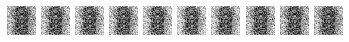

EPOCH: [2:40]   BATCH: [300:600]
	 G Loss = 1.29	 D Loss = 0.38
	 D(Real) = 0.8	 D(Fake) = 0.31


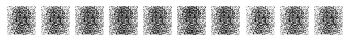

EPOCH: [2:40]   BATCH: [400:600]
	 G Loss = 2.03	 D Loss = 0.67
	 D(Real) = 0.68	 D(Fake) = 0.36


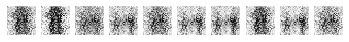

EPOCH: [2:40]   BATCH: [500:600]
	 G Loss = 1.06	 D Loss = 0.63
	 D(Real) = 0.56	 D(Fake) = 0.25


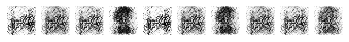

EPOCH: [3:40]   BATCH: [0:600]
	 G Loss = 0.7	 D Loss = 0.54
	 D(Real) = 0.57	 D(Fake) = 0.23


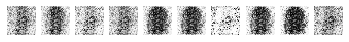

EPOCH: [3:40]   BATCH: [100:600]
	 G Loss = 1.86	 D Loss = 0.72
	 D(Real) = 0.8	 D(Fake) = 0.64


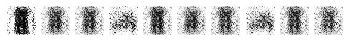

EPOCH: [3:40]   BATCH: [200:600]
	 G Loss = 0.97	 D Loss = 0.68
	 D(Real) = 0.53	 D(Fake) = 0.4


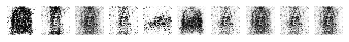

EPOCH: [3:40]   BATCH: [300:600]
	 G Loss = 0.82	 D Loss = 0.57
	 D(Real) = 0.55	 D(Fake) = 0.32


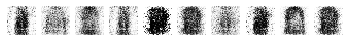

EPOCH: [3:40]   BATCH: [400:600]
	 G Loss = 1.66	 D Loss = 0.55
	 D(Real) = 0.82	 D(Fake) = 0.55


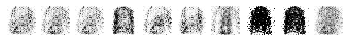

EPOCH: [3:40]   BATCH: [500:600]
	 G Loss = 1.44	 D Loss = 0.68
	 D(Real) = 0.73	 D(Fake) = 0.6


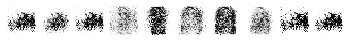

EPOCH: [4:40]   BATCH: [0:600]
	 G Loss = 1.63	 D Loss = 0.49
	 D(Real) = 0.67	 D(Fake) = 0.36


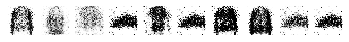

EPOCH: [4:40]   BATCH: [100:600]
	 G Loss = 2.16	 D Loss = 0.5
	 D(Real) = 0.8	 D(Fake) = 0.46


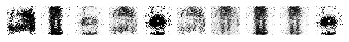

EPOCH: [4:40]   BATCH: [200:600]
	 G Loss = 1.05	 D Loss = 0.64
	 D(Real) = 0.59	 D(Fake) = 0.47


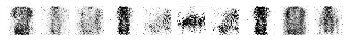

EPOCH: [4:40]   BATCH: [300:600]
	 G Loss = 0.82	 D Loss = 0.56
	 D(Real) = 0.53	 D(Fake) = 0.3


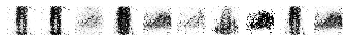

EPOCH: [4:40]   BATCH: [400:600]
	 G Loss = 1.32	 D Loss = 0.65
	 D(Real) = 0.71	 D(Fake) = 0.56


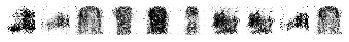

EPOCH: [4:40]   BATCH: [500:600]
	 G Loss = 0.82	 D Loss = 0.55
	 D(Real) = 0.56	 D(Fake) = 0.33


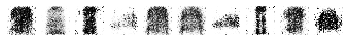

EPOCH: [5:40]   BATCH: [0:600]
	 G Loss = 0.69	 D Loss = 0.64
	 D(Real) = 0.47	 D(Fake) = 0.33


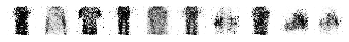

EPOCH: [5:40]   BATCH: [100:600]
	 G Loss = 0.76	 D Loss = 0.66
	 D(Real) = 0.5	 D(Fake) = 0.4


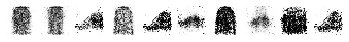

EPOCH: [5:40]   BATCH: [200:600]
	 G Loss = 1.04	 D Loss = 0.65
	 D(Real) = 0.6	 D(Fake) = 0.51


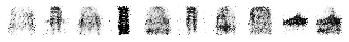

EPOCH: [5:40]   BATCH: [300:600]
	 G Loss = 0.78	 D Loss = 0.61
	 D(Real) = 0.5	 D(Fake) = 0.31


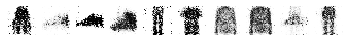

EPOCH: [5:40]   BATCH: [400:600]
	 G Loss = 0.78	 D Loss = 0.61
	 D(Real) = 0.51	 D(Fake) = 0.35


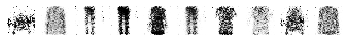

EPOCH: [5:40]   BATCH: [500:600]
	 G Loss = 1.23	 D Loss = 0.62
	 D(Real) = 0.67	 D(Fake) = 0.53


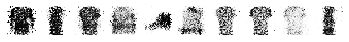

EPOCH: [6:40]   BATCH: [0:600]
	 G Loss = 1.17	 D Loss = 0.62
	 D(Real) = 0.59	 D(Fake) = 0.46


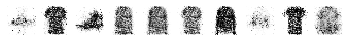

EPOCH: [6:40]   BATCH: [100:600]
	 G Loss = 0.77	 D Loss = 0.62
	 D(Real) = 0.49	 D(Fake) = 0.33


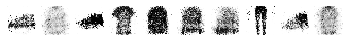

EPOCH: [6:40]   BATCH: [200:600]
	 G Loss = 0.93	 D Loss = 0.64
	 D(Real) = 0.59	 D(Fake) = 0.46


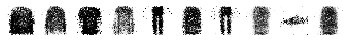

EPOCH: [6:40]   BATCH: [300:600]
	 G Loss = 0.82	 D Loss = 0.65
	 D(Real) = 0.54	 D(Fake) = 0.44


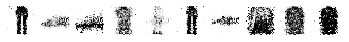

EPOCH: [6:40]   BATCH: [400:600]
	 G Loss = 0.74	 D Loss = 0.7
	 D(Real) = 0.46	 D(Fake) = 0.37


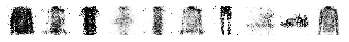

EPOCH: [6:40]   BATCH: [500:600]
	 G Loss = 0.72	 D Loss = 0.62
	 D(Real) = 0.5	 D(Fake) = 0.36


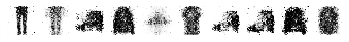

EPOCH: [7:40]   BATCH: [0:600]
	 G Loss = 0.62	 D Loss = 0.64
	 D(Real) = 0.49	 D(Fake) = 0.38


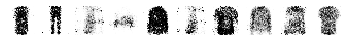

EPOCH: [7:40]   BATCH: [100:600]
	 G Loss = 0.94	 D Loss = 0.63
	 D(Real) = 0.55	 D(Fake) = 0.43


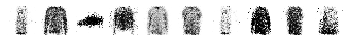

EPOCH: [7:40]   BATCH: [200:600]
	 G Loss = 1.28	 D Loss = 0.63
	 D(Real) = 0.65	 D(Fake) = 0.52


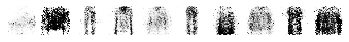

EPOCH: [7:40]   BATCH: [300:600]
	 G Loss = 0.79	 D Loss = 0.68
	 D(Real) = 0.52	 D(Fake) = 0.44


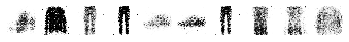

EPOCH: [7:40]   BATCH: [400:600]
	 G Loss = 0.93	 D Loss = 0.68
	 D(Real) = 0.55	 D(Fake) = 0.5


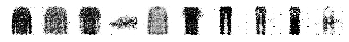

EPOCH: [7:40]   BATCH: [500:600]
	 G Loss = 1.13	 D Loss = 0.63
	 D(Real) = 0.66	 D(Fake) = 0.52


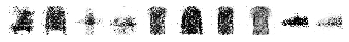

EPOCH: [8:40]   BATCH: [0:600]
	 G Loss = 0.95	 D Loss = 0.69
	 D(Real) = 0.58	 D(Fake) = 0.53


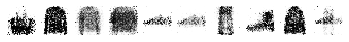

EPOCH: [8:40]   BATCH: [100:600]
	 G Loss = 0.95	 D Loss = 0.7
	 D(Real) = 0.57	 D(Fake) = 0.53


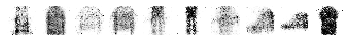

EPOCH: [8:40]   BATCH: [200:600]
	 G Loss = 0.84	 D Loss = 0.65
	 D(Real) = 0.51	 D(Fake) = 0.43


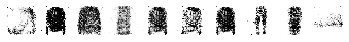

EPOCH: [8:40]   BATCH: [300:600]
	 G Loss = 0.83	 D Loss = 0.66
	 D(Real) = 0.5	 D(Fake) = 0.43


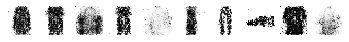

EPOCH: [8:40]   BATCH: [400:600]
	 G Loss = 0.99	 D Loss = 0.68
	 D(Real) = 0.61	 D(Fake) = 0.55


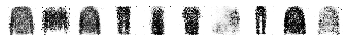

EPOCH: [8:40]   BATCH: [500:600]
	 G Loss = 0.85	 D Loss = 0.65
	 D(Real) = 0.55	 D(Fake) = 0.48


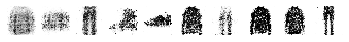

EPOCH: [9:40]   BATCH: [0:600]
	 G Loss = 0.89	 D Loss = 0.65
	 D(Real) = 0.55	 D(Fake) = 0.47


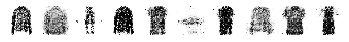

EPOCH: [9:40]   BATCH: [100:600]
	 G Loss = 0.72	 D Loss = 0.66
	 D(Real) = 0.55	 D(Fake) = 0.49


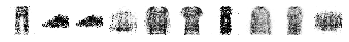

EPOCH: [9:40]   BATCH: [200:600]
	 G Loss = 0.87	 D Loss = 0.63
	 D(Real) = 0.59	 D(Fake) = 0.5


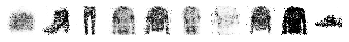

EPOCH: [9:40]   BATCH: [300:600]
	 G Loss = 0.69	 D Loss = 0.67
	 D(Real) = 0.47	 D(Fake) = 0.4


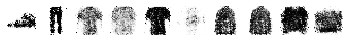

EPOCH: [9:40]   BATCH: [400:600]
	 G Loss = 0.79	 D Loss = 0.71
	 D(Real) = 0.55	 D(Fake) = 0.51


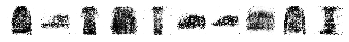

EPOCH: [9:40]   BATCH: [500:600]
	 G Loss = 0.85	 D Loss = 0.67
	 D(Real) = 0.55	 D(Fake) = 0.46


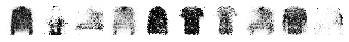

EPOCH: [10:40]   BATCH: [0:600]
	 G Loss = 0.98	 D Loss = 0.67
	 D(Real) = 0.56	 D(Fake) = 0.5


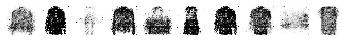

EPOCH: [10:40]   BATCH: [100:600]
	 G Loss = 0.91	 D Loss = 0.61
	 D(Real) = 0.55	 D(Fake) = 0.43


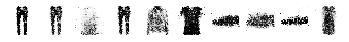

EPOCH: [10:40]   BATCH: [200:600]
	 G Loss = 0.93	 D Loss = 0.63
	 D(Real) = 0.57	 D(Fake) = 0.46


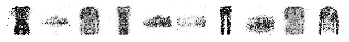

EPOCH: [10:40]   BATCH: [300:600]
	 G Loss = 0.96	 D Loss = 0.64
	 D(Real) = 0.59	 D(Fake) = 0.49


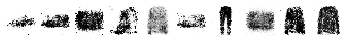

EPOCH: [10:40]   BATCH: [400:600]
	 G Loss = 1.07	 D Loss = 0.69
	 D(Real) = 0.57	 D(Fake) = 0.51


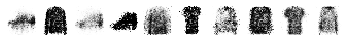

EPOCH: [10:40]   BATCH: [500:600]
	 G Loss = 0.86	 D Loss = 0.64
	 D(Real) = 0.51	 D(Fake) = 0.41


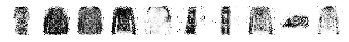

EPOCH: [11:40]   BATCH: [0:600]
	 G Loss = 1.03	 D Loss = 0.69
	 D(Real) = 0.54	 D(Fake) = 0.48


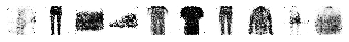

EPOCH: [11:40]   BATCH: [100:600]
	 G Loss = 1.1	 D Loss = 0.62
	 D(Real) = 0.62	 D(Fake) = 0.49


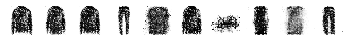

EPOCH: [11:40]   BATCH: [200:600]
	 G Loss = 0.77	 D Loss = 0.69
	 D(Real) = 0.57	 D(Fake) = 0.53


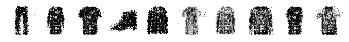

EPOCH: [11:40]   BATCH: [300:600]
	 G Loss = 0.94	 D Loss = 0.64
	 D(Real) = 0.54	 D(Fake) = 0.44


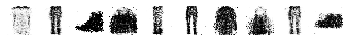

EPOCH: [11:40]   BATCH: [400:600]
	 G Loss = 0.96	 D Loss = 0.63
	 D(Real) = 0.59	 D(Fake) = 0.49


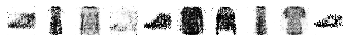

EPOCH: [11:40]   BATCH: [500:600]
	 G Loss = 0.93	 D Loss = 0.65
	 D(Real) = 0.59	 D(Fake) = 0.5


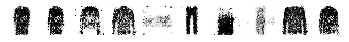

EPOCH: [12:40]   BATCH: [0:600]
	 G Loss = 0.81	 D Loss = 0.7
	 D(Real) = 0.51	 D(Fake) = 0.48


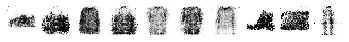

EPOCH: [12:40]   BATCH: [100:600]
	 G Loss = 0.72	 D Loss = 0.63
	 D(Real) = 0.54	 D(Fake) = 0.44


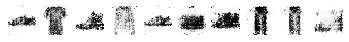

EPOCH: [12:40]   BATCH: [200:600]
	 G Loss = 0.9	 D Loss = 0.69
	 D(Real) = 0.58	 D(Fake) = 0.52


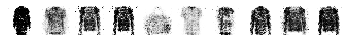

EPOCH: [12:40]   BATCH: [300:600]
	 G Loss = 0.89	 D Loss = 0.62
	 D(Real) = 0.55	 D(Fake) = 0.43


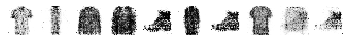

EPOCH: [12:40]   BATCH: [400:600]
	 G Loss = 0.9	 D Loss = 0.65
	 D(Real) = 0.54	 D(Fake) = 0.45


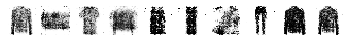

EPOCH: [12:40]   BATCH: [500:600]
	 G Loss = 0.97	 D Loss = 0.65
	 D(Real) = 0.61	 D(Fake) = 0.51


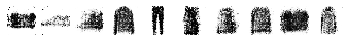

EPOCH: [13:40]   BATCH: [0:600]
	 G Loss = 0.73	 D Loss = 0.64
	 D(Real) = 0.51	 D(Fake) = 0.4


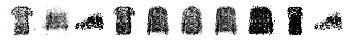

EPOCH: [13:40]   BATCH: [100:600]
	 G Loss = 0.88	 D Loss = 0.64
	 D(Real) = 0.54	 D(Fake) = 0.44


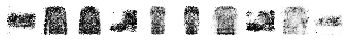

EPOCH: [13:40]   BATCH: [200:600]
	 G Loss = 0.84	 D Loss = 0.69
	 D(Real) = 0.49	 D(Fake) = 0.44


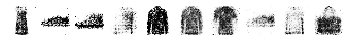

EPOCH: [13:40]   BATCH: [300:600]
	 G Loss = 0.77	 D Loss = 0.66
	 D(Real) = 0.54	 D(Fake) = 0.48


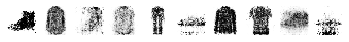

EPOCH: [13:40]   BATCH: [400:600]
	 G Loss = 0.83	 D Loss = 0.69
	 D(Real) = 0.53	 D(Fake) = 0.45


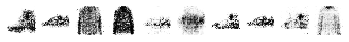

EPOCH: [13:40]   BATCH: [500:600]
	 G Loss = 0.94	 D Loss = 0.66
	 D(Real) = 0.58	 D(Fake) = 0.5


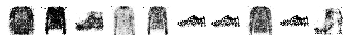

EPOCH: [14:40]   BATCH: [0:600]
	 G Loss = 0.86	 D Loss = 0.68
	 D(Real) = 0.53	 D(Fake) = 0.49


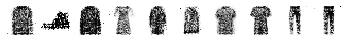

EPOCH: [14:40]   BATCH: [100:600]
	 G Loss = 0.82	 D Loss = 0.65
	 D(Real) = 0.51	 D(Fake) = 0.43


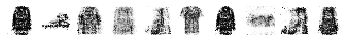

EPOCH: [14:40]   BATCH: [200:600]
	 G Loss = 0.75	 D Loss = 0.62
	 D(Real) = 0.5	 D(Fake) = 0.39


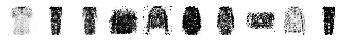

EPOCH: [14:40]   BATCH: [300:600]
	 G Loss = 0.78	 D Loss = 0.63
	 D(Real) = 0.52	 D(Fake) = 0.43


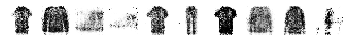

EPOCH: [14:40]   BATCH: [400:600]
	 G Loss = 0.93	 D Loss = 0.63
	 D(Real) = 0.58	 D(Fake) = 0.48


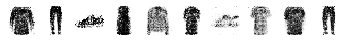

EPOCH: [14:40]   BATCH: [500:600]
	 G Loss = 0.93	 D Loss = 0.67
	 D(Real) = 0.51	 D(Fake) = 0.43


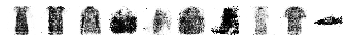

EPOCH: [15:40]   BATCH: [0:600]
	 G Loss = 0.84	 D Loss = 0.64
	 D(Real) = 0.54	 D(Fake) = 0.46


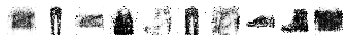

EPOCH: [15:40]   BATCH: [100:600]
	 G Loss = 0.86	 D Loss = 0.67
	 D(Real) = 0.52	 D(Fake) = 0.44


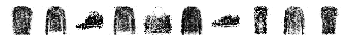

EPOCH: [15:40]   BATCH: [200:600]
	 G Loss = 0.93	 D Loss = 0.68
	 D(Real) = 0.52	 D(Fake) = 0.46


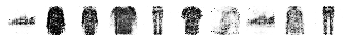

EPOCH: [15:40]   BATCH: [300:600]
	 G Loss = 0.89	 D Loss = 0.63
	 D(Real) = 0.57	 D(Fake) = 0.48


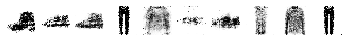

EPOCH: [15:40]   BATCH: [400:600]
	 G Loss = 0.87	 D Loss = 0.68
	 D(Real) = 0.51	 D(Fake) = 0.47


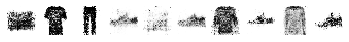

EPOCH: [15:40]   BATCH: [500:600]
	 G Loss = 0.8	 D Loss = 0.65
	 D(Real) = 0.52	 D(Fake) = 0.44


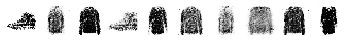

EPOCH: [16:40]   BATCH: [0:600]
	 G Loss = 0.87	 D Loss = 0.66
	 D(Real) = 0.57	 D(Fake) = 0.5


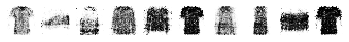

EPOCH: [16:40]   BATCH: [100:600]
	 G Loss = 0.9	 D Loss = 0.6
	 D(Real) = 0.62	 D(Fake) = 0.49


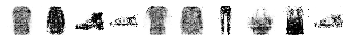

EPOCH: [16:40]   BATCH: [200:600]
	 G Loss = 0.75	 D Loss = 0.68
	 D(Real) = 0.51	 D(Fake) = 0.46


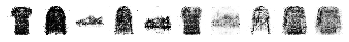

EPOCH: [16:40]   BATCH: [300:600]
	 G Loss = 0.84	 D Loss = 0.63
	 D(Real) = 0.55	 D(Fake) = 0.43


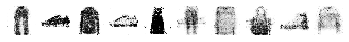

EPOCH: [16:40]   BATCH: [400:600]
	 G Loss = 0.82	 D Loss = 0.69
	 D(Real) = 0.55	 D(Fake) = 0.51


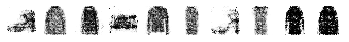

EPOCH: [16:40]   BATCH: [500:600]
	 G Loss = 0.88	 D Loss = 0.65
	 D(Real) = 0.55	 D(Fake) = 0.47


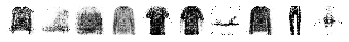

EPOCH: [17:40]   BATCH: [0:600]
	 G Loss = 0.81	 D Loss = 0.65
	 D(Real) = 0.53	 D(Fake) = 0.44


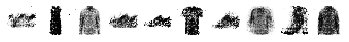

EPOCH: [17:40]   BATCH: [100:600]
	 G Loss = 0.79	 D Loss = 0.65
	 D(Real) = 0.52	 D(Fake) = 0.45


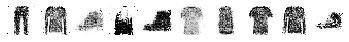

EPOCH: [17:40]   BATCH: [200:600]
	 G Loss = 0.74	 D Loss = 0.67
	 D(Real) = 0.51	 D(Fake) = 0.46


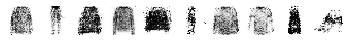

EPOCH: [17:40]   BATCH: [300:600]
	 G Loss = 0.9	 D Loss = 0.67
	 D(Real) = 0.53	 D(Fake) = 0.48


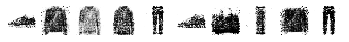

EPOCH: [17:40]   BATCH: [400:600]
	 G Loss = 0.77	 D Loss = 0.68
	 D(Real) = 0.51	 D(Fake) = 0.46


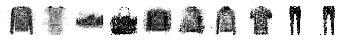

EPOCH: [17:40]   BATCH: [500:600]
	 G Loss = 0.78	 D Loss = 0.69
	 D(Real) = 0.53	 D(Fake) = 0.5


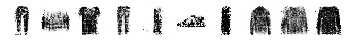

EPOCH: [18:40]   BATCH: [0:600]
	 G Loss = 0.83	 D Loss = 0.63
	 D(Real) = 0.57	 D(Fake) = 0.48


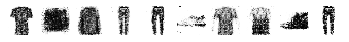

EPOCH: [18:40]   BATCH: [100:600]
	 G Loss = 0.8	 D Loss = 0.66
	 D(Real) = 0.5	 D(Fake) = 0.43


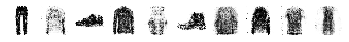

EPOCH: [18:40]   BATCH: [200:600]
	 G Loss = 0.95	 D Loss = 0.68
	 D(Real) = 0.57	 D(Fake) = 0.51


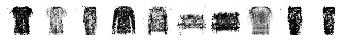

EPOCH: [18:40]   BATCH: [300:600]
	 G Loss = 0.77	 D Loss = 0.68
	 D(Real) = 0.53	 D(Fake) = 0.49


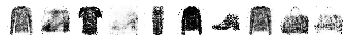

EPOCH: [18:40]   BATCH: [400:600]
	 G Loss = 0.92	 D Loss = 0.68
	 D(Real) = 0.53	 D(Fake) = 0.48


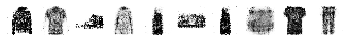

EPOCH: [18:40]   BATCH: [500:600]
	 G Loss = 0.74	 D Loss = 0.62
	 D(Real) = 0.53	 D(Fake) = 0.42


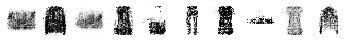

EPOCH: [19:40]   BATCH: [0:600]
	 G Loss = 0.93	 D Loss = 0.66
	 D(Real) = 0.53	 D(Fake) = 0.47


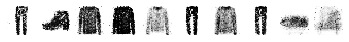

EPOCH: [19:40]   BATCH: [100:600]
	 G Loss = 0.76	 D Loss = 0.66
	 D(Real) = 0.53	 D(Fake) = 0.46


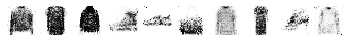

EPOCH: [19:40]   BATCH: [200:600]
	 G Loss = 0.77	 D Loss = 0.63
	 D(Real) = 0.53	 D(Fake) = 0.43


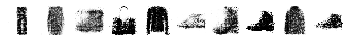

EPOCH: [19:40]   BATCH: [300:600]
	 G Loss = 0.97	 D Loss = 0.66
	 D(Real) = 0.53	 D(Fake) = 0.46


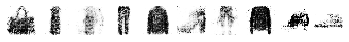

EPOCH: [19:40]   BATCH: [400:600]
	 G Loss = 0.81	 D Loss = 0.68
	 D(Real) = 0.51	 D(Fake) = 0.47


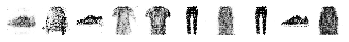

EPOCH: [19:40]   BATCH: [500:600]
	 G Loss = 0.82	 D Loss = 0.68
	 D(Real) = 0.5	 D(Fake) = 0.46


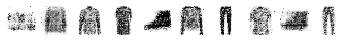

EPOCH: [20:40]   BATCH: [0:600]
	 G Loss = 0.9	 D Loss = 0.69
	 D(Real) = 0.54	 D(Fake) = 0.5


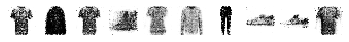

EPOCH: [20:40]   BATCH: [100:600]
	 G Loss = 0.91	 D Loss = 0.65
	 D(Real) = 0.54	 D(Fake) = 0.46


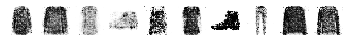

EPOCH: [20:40]   BATCH: [200:600]
	 G Loss = 0.76	 D Loss = 0.69
	 D(Real) = 0.51	 D(Fake) = 0.48


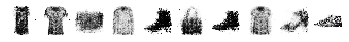

EPOCH: [20:40]   BATCH: [300:600]
	 G Loss = 0.83	 D Loss = 0.63
	 D(Real) = 0.53	 D(Fake) = 0.45


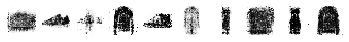

EPOCH: [20:40]   BATCH: [400:600]
	 G Loss = 0.81	 D Loss = 0.66
	 D(Real) = 0.51	 D(Fake) = 0.45


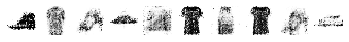

EPOCH: [20:40]   BATCH: [500:600]
	 G Loss = 0.9	 D Loss = 0.68
	 D(Real) = 0.54	 D(Fake) = 0.48


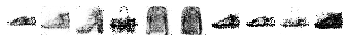

EPOCH: [21:40]   BATCH: [0:600]
	 G Loss = 0.8	 D Loss = 0.69
	 D(Real) = 0.49	 D(Fake) = 0.45


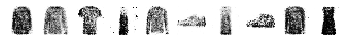

EPOCH: [21:40]   BATCH: [100:600]
	 G Loss = 0.88	 D Loss = 0.67
	 D(Real) = 0.55	 D(Fake) = 0.49


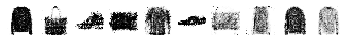

EPOCH: [21:40]   BATCH: [200:600]
	 G Loss = 0.79	 D Loss = 0.69
	 D(Real) = 0.54	 D(Fake) = 0.49


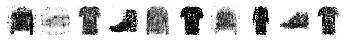

EPOCH: [21:40]   BATCH: [300:600]
	 G Loss = 0.92	 D Loss = 0.68
	 D(Real) = 0.54	 D(Fake) = 0.49


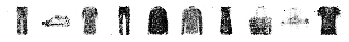

EPOCH: [21:40]   BATCH: [400:600]
	 G Loss = 0.75	 D Loss = 0.7
	 D(Real) = 0.52	 D(Fake) = 0.49


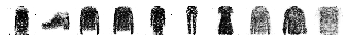

EPOCH: [21:40]   BATCH: [500:600]
	 G Loss = 0.76	 D Loss = 0.68
	 D(Real) = 0.55	 D(Fake) = 0.49


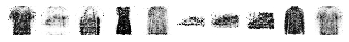

EPOCH: [22:40]   BATCH: [0:600]
	 G Loss = 0.81	 D Loss = 0.65
	 D(Real) = 0.52	 D(Fake) = 0.45


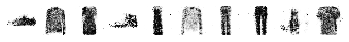

EPOCH: [22:40]   BATCH: [100:600]
	 G Loss = 0.83	 D Loss = 0.7
	 D(Real) = 0.51	 D(Fake) = 0.49


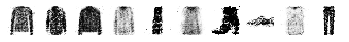

EPOCH: [22:40]   BATCH: [200:600]
	 G Loss = 0.69	 D Loss = 0.68
	 D(Real) = 0.49	 D(Fake) = 0.44


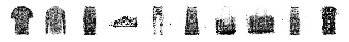

EPOCH: [22:40]   BATCH: [300:600]
	 G Loss = 0.79	 D Loss = 0.68
	 D(Real) = 0.54	 D(Fake) = 0.48


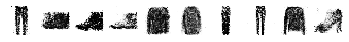

EPOCH: [22:40]   BATCH: [400:600]
	 G Loss = 0.75	 D Loss = 0.65
	 D(Real) = 0.57	 D(Fake) = 0.5


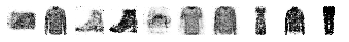

EPOCH: [22:40]   BATCH: [500:600]
	 G Loss = 0.89	 D Loss = 0.64
	 D(Real) = 0.55	 D(Fake) = 0.48


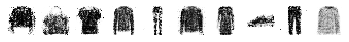

EPOCH: [23:40]   BATCH: [0:600]
	 G Loss = 0.76	 D Loss = 0.67
	 D(Real) = 0.53	 D(Fake) = 0.47


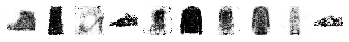

EPOCH: [23:40]   BATCH: [100:600]
	 G Loss = 0.91	 D Loss = 0.64
	 D(Real) = 0.57	 D(Fake) = 0.47


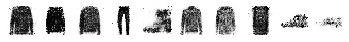

EPOCH: [23:40]   BATCH: [200:600]
	 G Loss = 0.92	 D Loss = 0.68
	 D(Real) = 0.52	 D(Fake) = 0.47


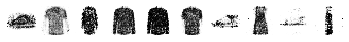

EPOCH: [23:40]   BATCH: [300:600]
	 G Loss = 0.91	 D Loss = 0.65
	 D(Real) = 0.57	 D(Fake) = 0.49


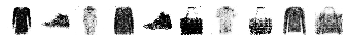

EPOCH: [23:40]   BATCH: [400:600]
	 G Loss = 0.94	 D Loss = 0.67
	 D(Real) = 0.54	 D(Fake) = 0.47


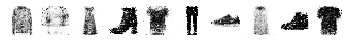

EPOCH: [23:40]   BATCH: [500:600]
	 G Loss = 0.79	 D Loss = 0.67
	 D(Real) = 0.5	 D(Fake) = 0.45


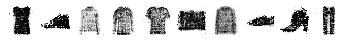

EPOCH: [24:40]   BATCH: [0:600]
	 G Loss = 0.91	 D Loss = 0.67
	 D(Real) = 0.55	 D(Fake) = 0.49


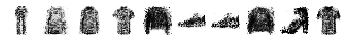

EPOCH: [24:40]   BATCH: [100:600]
	 G Loss = 0.85	 D Loss = 0.66
	 D(Real) = 0.53	 D(Fake) = 0.47


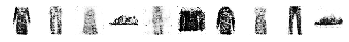

EPOCH: [24:40]   BATCH: [200:600]
	 G Loss = 0.76	 D Loss = 0.69
	 D(Real) = 0.53	 D(Fake) = 0.49


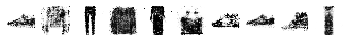

EPOCH: [24:40]   BATCH: [300:600]
	 G Loss = 0.81	 D Loss = 0.69
	 D(Real) = 0.5	 D(Fake) = 0.46


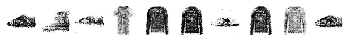

EPOCH: [24:40]   BATCH: [400:600]
	 G Loss = 0.79	 D Loss = 0.65
	 D(Real) = 0.5	 D(Fake) = 0.41


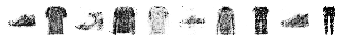

EPOCH: [24:40]   BATCH: [500:600]
	 G Loss = 0.89	 D Loss = 0.65
	 D(Real) = 0.56	 D(Fake) = 0.48


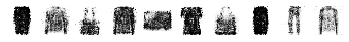

EPOCH: [25:40]   BATCH: [0:600]
	 G Loss = 0.86	 D Loss = 0.68
	 D(Real) = 0.56	 D(Fake) = 0.5


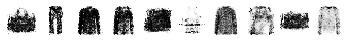

EPOCH: [25:40]   BATCH: [100:600]
	 G Loss = 0.82	 D Loss = 0.65
	 D(Real) = 0.53	 D(Fake) = 0.45


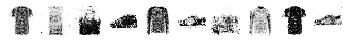

EPOCH: [25:40]   BATCH: [200:600]
	 G Loss = 0.73	 D Loss = 0.66
	 D(Real) = 0.51	 D(Fake) = 0.43


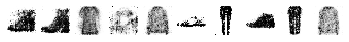

EPOCH: [25:40]   BATCH: [300:600]
	 G Loss = 0.8	 D Loss = 0.66
	 D(Real) = 0.53	 D(Fake) = 0.46


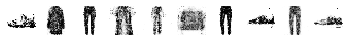

EPOCH: [25:40]   BATCH: [400:600]
	 G Loss = 0.79	 D Loss = 0.67
	 D(Real) = 0.53	 D(Fake) = 0.46


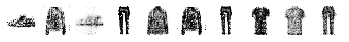

EPOCH: [25:40]   BATCH: [500:600]
	 G Loss = 0.83	 D Loss = 0.65
	 D(Real) = 0.51	 D(Fake) = 0.44


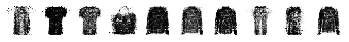

EPOCH: [26:40]   BATCH: [0:600]
	 G Loss = 0.91	 D Loss = 0.64
	 D(Real) = 0.56	 D(Fake) = 0.46


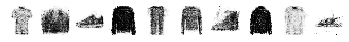

EPOCH: [26:40]   BATCH: [100:600]
	 G Loss = 0.94	 D Loss = 0.67
	 D(Real) = 0.56	 D(Fake) = 0.49


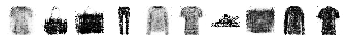

EPOCH: [26:40]   BATCH: [200:600]
	 G Loss = 0.88	 D Loss = 0.65
	 D(Real) = 0.52	 D(Fake) = 0.44


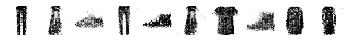

EPOCH: [26:40]   BATCH: [300:600]
	 G Loss = 0.85	 D Loss = 0.68
	 D(Real) = 0.53	 D(Fake) = 0.47


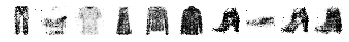

EPOCH: [26:40]   BATCH: [400:600]
	 G Loss = 0.75	 D Loss = 0.67
	 D(Real) = 0.51	 D(Fake) = 0.44


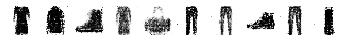

EPOCH: [26:40]   BATCH: [500:600]
	 G Loss = 0.86	 D Loss = 0.65
	 D(Real) = 0.52	 D(Fake) = 0.45


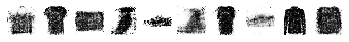

EPOCH: [27:40]   BATCH: [0:600]
	 G Loss = 0.82	 D Loss = 0.66
	 D(Real) = 0.53	 D(Fake) = 0.46


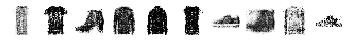

EPOCH: [27:40]   BATCH: [100:600]
	 G Loss = 0.82	 D Loss = 0.65
	 D(Real) = 0.52	 D(Fake) = 0.45


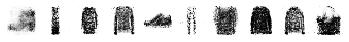

EPOCH: [27:40]   BATCH: [200:600]
	 G Loss = 0.91	 D Loss = 0.67
	 D(Real) = 0.54	 D(Fake) = 0.48


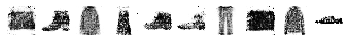

EPOCH: [27:40]   BATCH: [300:600]
	 G Loss = 0.85	 D Loss = 0.63
	 D(Real) = 0.51	 D(Fake) = 0.41


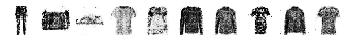

EPOCH: [27:40]   BATCH: [400:600]
	 G Loss = 0.89	 D Loss = 0.66
	 D(Real) = 0.54	 D(Fake) = 0.48


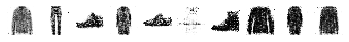

EPOCH: [27:40]   BATCH: [500:600]
	 G Loss = 0.87	 D Loss = 0.68
	 D(Real) = 0.55	 D(Fake) = 0.5


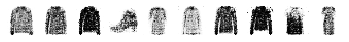

EPOCH: [28:40]   BATCH: [0:600]
	 G Loss = 0.74	 D Loss = 0.67
	 D(Real) = 0.48	 D(Fake) = 0.41


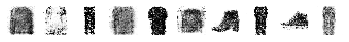

EPOCH: [28:40]   BATCH: [100:600]
	 G Loss = 0.74	 D Loss = 0.66
	 D(Real) = 0.51	 D(Fake) = 0.45


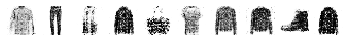

EPOCH: [28:40]   BATCH: [200:600]
	 G Loss = 0.9	 D Loss = 0.66
	 D(Real) = 0.56	 D(Fake) = 0.49


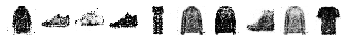

EPOCH: [28:40]   BATCH: [300:600]
	 G Loss = 0.77	 D Loss = 0.65
	 D(Real) = 0.48	 D(Fake) = 0.4


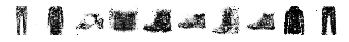

EPOCH: [28:40]   BATCH: [400:600]
	 G Loss = 0.84	 D Loss = 0.68
	 D(Real) = 0.53	 D(Fake) = 0.47


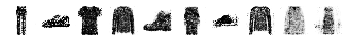

EPOCH: [28:40]   BATCH: [500:600]
	 G Loss = 0.83	 D Loss = 0.69
	 D(Real) = 0.53	 D(Fake) = 0.48


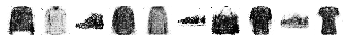

EPOCH: [29:40]   BATCH: [0:600]
	 G Loss = 0.99	 D Loss = 0.64
	 D(Real) = 0.57	 D(Fake) = 0.48


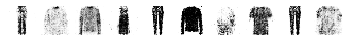

EPOCH: [29:40]   BATCH: [100:600]
	 G Loss = 0.82	 D Loss = 0.66
	 D(Real) = 0.55	 D(Fake) = 0.48


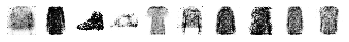

EPOCH: [29:40]   BATCH: [200:600]
	 G Loss = 0.81	 D Loss = 0.7
	 D(Real) = 0.5	 D(Fake) = 0.46


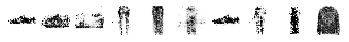

EPOCH: [29:40]   BATCH: [300:600]
	 G Loss = 0.83	 D Loss = 0.62
	 D(Real) = 0.57	 D(Fake) = 0.45


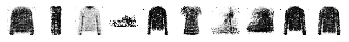

EPOCH: [29:40]   BATCH: [400:600]
	 G Loss = 0.73	 D Loss = 0.67
	 D(Real) = 0.51	 D(Fake) = 0.44


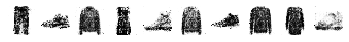

EPOCH: [29:40]   BATCH: [500:600]
	 G Loss = 0.86	 D Loss = 0.68
	 D(Real) = 0.5	 D(Fake) = 0.45


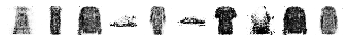

EPOCH: [30:40]   BATCH: [0:600]
	 G Loss = 0.81	 D Loss = 0.65
	 D(Real) = 0.54	 D(Fake) = 0.46


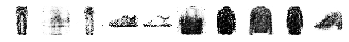

EPOCH: [30:40]   BATCH: [100:600]
	 G Loss = 0.83	 D Loss = 0.64
	 D(Real) = 0.54	 D(Fake) = 0.45


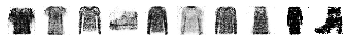

EPOCH: [30:40]   BATCH: [200:600]
	 G Loss = 0.85	 D Loss = 0.67
	 D(Real) = 0.53	 D(Fake) = 0.46


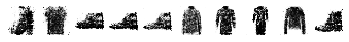

EPOCH: [30:40]   BATCH: [300:600]
	 G Loss = 0.78	 D Loss = 0.66
	 D(Real) = 0.55	 D(Fake) = 0.47


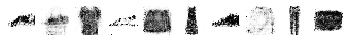

EPOCH: [30:40]   BATCH: [400:600]
	 G Loss = 0.82	 D Loss = 0.68
	 D(Real) = 0.49	 D(Fake) = 0.44


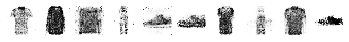

EPOCH: [30:40]   BATCH: [500:600]
	 G Loss = 0.81	 D Loss = 0.66
	 D(Real) = 0.57	 D(Fake) = 0.5


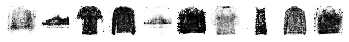

EPOCH: [31:40]   BATCH: [0:600]
	 G Loss = 0.84	 D Loss = 0.65
	 D(Real) = 0.56	 D(Fake) = 0.47


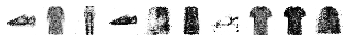

EPOCH: [31:40]   BATCH: [100:600]
	 G Loss = 0.9	 D Loss = 0.67
	 D(Real) = 0.56	 D(Fake) = 0.5


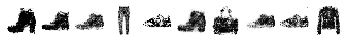

EPOCH: [31:40]   BATCH: [200:600]
	 G Loss = 0.85	 D Loss = 0.69
	 D(Real) = 0.54	 D(Fake) = 0.49


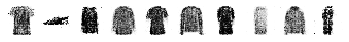

EPOCH: [31:40]   BATCH: [300:600]
	 G Loss = 0.75	 D Loss = 0.6
	 D(Real) = 0.54	 D(Fake) = 0.41


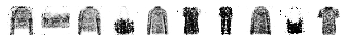

EPOCH: [31:40]   BATCH: [400:600]
	 G Loss = 0.98	 D Loss = 0.62
	 D(Real) = 0.58	 D(Fake) = 0.46


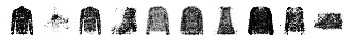

EPOCH: [31:40]   BATCH: [500:600]
	 G Loss = 0.86	 D Loss = 0.65
	 D(Real) = 0.57	 D(Fake) = 0.49


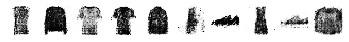

EPOCH: [32:40]   BATCH: [0:600]
	 G Loss = 0.86	 D Loss = 0.61
	 D(Real) = 0.55	 D(Fake) = 0.43


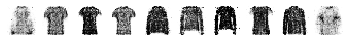

EPOCH: [32:40]   BATCH: [100:600]
	 G Loss = 0.94	 D Loss = 0.64
	 D(Real) = 0.58	 D(Fake) = 0.49


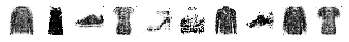

EPOCH: [32:40]   BATCH: [200:600]
	 G Loss = 0.79	 D Loss = 0.66
	 D(Real) = 0.52	 D(Fake) = 0.45


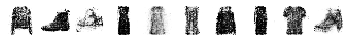

EPOCH: [32:40]   BATCH: [300:600]
	 G Loss = 0.98	 D Loss = 0.68
	 D(Real) = 0.54	 D(Fake) = 0.48


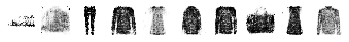

EPOCH: [32:40]   BATCH: [400:600]
	 G Loss = 0.96	 D Loss = 0.66
	 D(Real) = 0.57	 D(Fake) = 0.48


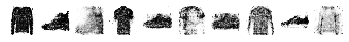

EPOCH: [32:40]   BATCH: [500:600]
	 G Loss = 0.84	 D Loss = 0.71
	 D(Real) = 0.54	 D(Fake) = 0.5


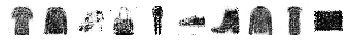

EPOCH: [33:40]   BATCH: [0:600]
	 G Loss = 0.93	 D Loss = 0.64
	 D(Real) = 0.58	 D(Fake) = 0.49


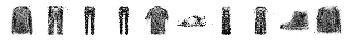

EPOCH: [33:40]   BATCH: [100:600]
	 G Loss = 0.84	 D Loss = 0.66
	 D(Real) = 0.5	 D(Fake) = 0.43


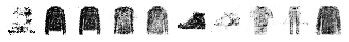

EPOCH: [33:40]   BATCH: [200:600]
	 G Loss = 0.83	 D Loss = 0.65
	 D(Real) = 0.52	 D(Fake) = 0.44


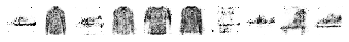

EPOCH: [33:40]   BATCH: [300:600]
	 G Loss = 0.75	 D Loss = 0.64
	 D(Real) = 0.53	 D(Fake) = 0.43


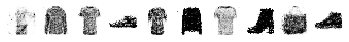

EPOCH: [33:40]   BATCH: [400:600]
	 G Loss = 0.79	 D Loss = 0.64
	 D(Real) = 0.52	 D(Fake) = 0.43


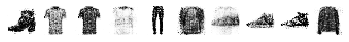

EPOCH: [33:40]   BATCH: [500:600]
	 G Loss = 0.82	 D Loss = 0.65
	 D(Real) = 0.53	 D(Fake) = 0.44


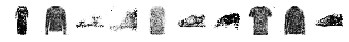

EPOCH: [34:40]   BATCH: [0:600]
	 G Loss = 0.98	 D Loss = 0.66
	 D(Real) = 0.61	 D(Fake) = 0.53


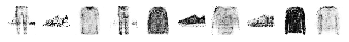

EPOCH: [34:40]   BATCH: [100:600]
	 G Loss = 0.71	 D Loss = 0.63
	 D(Real) = 0.54	 D(Fake) = 0.44


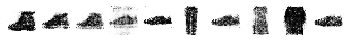

EPOCH: [34:40]   BATCH: [200:600]
	 G Loss = 0.83	 D Loss = 0.61
	 D(Real) = 0.54	 D(Fake) = 0.42


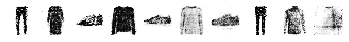

EPOCH: [34:40]   BATCH: [300:600]
	 G Loss = 0.83	 D Loss = 0.65
	 D(Real) = 0.54	 D(Fake) = 0.46


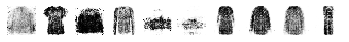

EPOCH: [34:40]   BATCH: [400:600]
	 G Loss = 0.91	 D Loss = 0.68
	 D(Real) = 0.54	 D(Fake) = 0.49


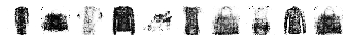

EPOCH: [34:40]   BATCH: [500:600]
	 G Loss = 0.89	 D Loss = 0.62
	 D(Real) = 0.54	 D(Fake) = 0.43


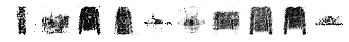

EPOCH: [35:40]   BATCH: [0:600]
	 G Loss = 0.98	 D Loss = 0.7
	 D(Real) = 0.55	 D(Fake) = 0.52


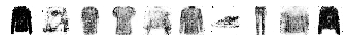

EPOCH: [35:40]   BATCH: [100:600]
	 G Loss = 0.74	 D Loss = 0.69
	 D(Real) = 0.48	 D(Fake) = 0.43


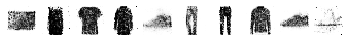

EPOCH: [35:40]   BATCH: [200:600]
	 G Loss = 0.81	 D Loss = 0.65
	 D(Real) = 0.49	 D(Fake) = 0.41


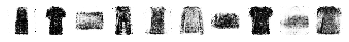

EPOCH: [35:40]   BATCH: [300:600]
	 G Loss = 0.89	 D Loss = 0.66
	 D(Real) = 0.53	 D(Fake) = 0.46


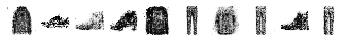

EPOCH: [35:40]   BATCH: [400:600]
	 G Loss = 0.9	 D Loss = 0.65
	 D(Real) = 0.58	 D(Fake) = 0.5


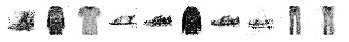

EPOCH: [35:40]   BATCH: [500:600]
	 G Loss = 0.87	 D Loss = 0.66
	 D(Real) = 0.57	 D(Fake) = 0.5


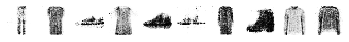

EPOCH: [36:40]   BATCH: [0:600]
	 G Loss = 0.85	 D Loss = 0.67
	 D(Real) = 0.51	 D(Fake) = 0.45


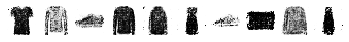

EPOCH: [36:40]   BATCH: [100:600]
	 G Loss = 0.86	 D Loss = 0.63
	 D(Real) = 0.52	 D(Fake) = 0.43


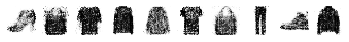

EPOCH: [36:40]   BATCH: [200:600]
	 G Loss = 0.78	 D Loss = 0.69
	 D(Real) = 0.54	 D(Fake) = 0.5


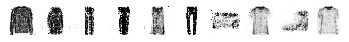

EPOCH: [36:40]   BATCH: [300:600]
	 G Loss = 0.82	 D Loss = 0.65
	 D(Real) = 0.58	 D(Fake) = 0.49


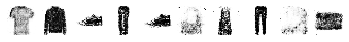

EPOCH: [36:40]   BATCH: [400:600]
	 G Loss = 0.92	 D Loss = 0.65
	 D(Real) = 0.54	 D(Fake) = 0.46


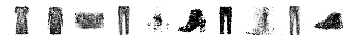

EPOCH: [36:40]   BATCH: [500:600]
	 G Loss = 0.93	 D Loss = 0.65
	 D(Real) = 0.55	 D(Fake) = 0.48


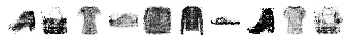

EPOCH: [37:40]   BATCH: [0:600]
	 G Loss = 0.94	 D Loss = 0.66
	 D(Real) = 0.57	 D(Fake) = 0.48


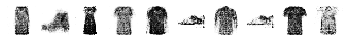

EPOCH: [37:40]   BATCH: [100:600]
	 G Loss = 0.77	 D Loss = 0.68
	 D(Real) = 0.5	 D(Fake) = 0.44


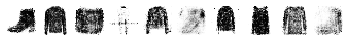

EPOCH: [37:40]   BATCH: [200:600]
	 G Loss = 0.92	 D Loss = 0.68
	 D(Real) = 0.56	 D(Fake) = 0.5


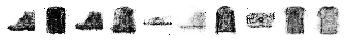

EPOCH: [37:40]   BATCH: [300:600]
	 G Loss = 0.77	 D Loss = 0.64
	 D(Real) = 0.51	 D(Fake) = 0.43


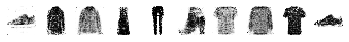

EPOCH: [37:40]   BATCH: [400:600]
	 G Loss = 0.92	 D Loss = 0.69
	 D(Real) = 0.56	 D(Fake) = 0.5


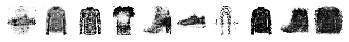

EPOCH: [37:40]   BATCH: [500:600]
	 G Loss = 0.87	 D Loss = 0.66
	 D(Real) = 0.56	 D(Fake) = 0.48


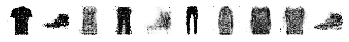

EPOCH: [38:40]   BATCH: [0:600]
	 G Loss = 0.79	 D Loss = 0.68
	 D(Real) = 0.51	 D(Fake) = 0.45


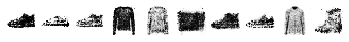

EPOCH: [38:40]   BATCH: [100:600]
	 G Loss = 0.87	 D Loss = 0.69
	 D(Real) = 0.51	 D(Fake) = 0.46


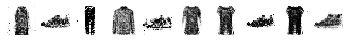

EPOCH: [38:40]   BATCH: [200:600]
	 G Loss = 0.89	 D Loss = 0.68
	 D(Real) = 0.54	 D(Fake) = 0.49


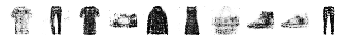

EPOCH: [38:40]   BATCH: [300:600]
	 G Loss = 0.85	 D Loss = 0.64
	 D(Real) = 0.55	 D(Fake) = 0.46


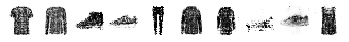

EPOCH: [38:40]   BATCH: [400:600]
	 G Loss = 0.85	 D Loss = 0.65
	 D(Real) = 0.58	 D(Fake) = 0.5


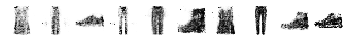

EPOCH: [38:40]   BATCH: [500:600]
	 G Loss = 0.83	 D Loss = 0.64
	 D(Real) = 0.52	 D(Fake) = 0.43


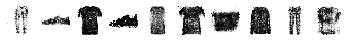

EPOCH: [39:40]   BATCH: [0:600]
	 G Loss = 0.89	 D Loss = 0.72
	 D(Real) = 0.54	 D(Fake) = 0.5


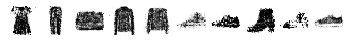

EPOCH: [39:40]   BATCH: [100:600]
	 G Loss = 0.77	 D Loss = 0.65
	 D(Real) = 0.57	 D(Fake) = 0.49


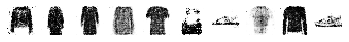

EPOCH: [39:40]   BATCH: [200:600]
	 G Loss = 0.86	 D Loss = 0.68
	 D(Real) = 0.55	 D(Fake) = 0.48


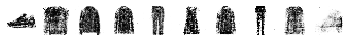

EPOCH: [39:40]   BATCH: [300:600]
	 G Loss = 0.8	 D Loss = 0.67
	 D(Real) = 0.52	 D(Fake) = 0.46


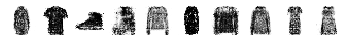

EPOCH: [39:40]   BATCH: [400:600]
	 G Loss = 0.97	 D Loss = 0.67
	 D(Real) = 0.53	 D(Fake) = 0.48


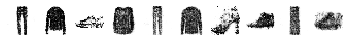

EPOCH: [39:40]   BATCH: [500:600]
	 G Loss = 0.81	 D Loss = 0.68
	 D(Real) = 0.48	 D(Fake) = 0.43


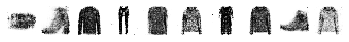

EPOCH: [40:40]   BATCH: [0:600]
	 G Loss = 0.8	 D Loss = 0.66
	 D(Real) = 0.54	 D(Fake) = 0.48


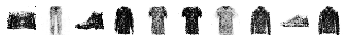

EPOCH: [40:40]   BATCH: [100:600]
	 G Loss = 0.9	 D Loss = 0.67
	 D(Real) = 0.53	 D(Fake) = 0.47


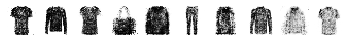

EPOCH: [40:40]   BATCH: [200:600]
	 G Loss = 0.85	 D Loss = 0.64
	 D(Real) = 0.54	 D(Fake) = 0.45


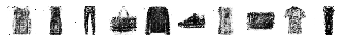

EPOCH: [40:40]   BATCH: [300:600]
	 G Loss = 0.85	 D Loss = 0.65
	 D(Real) = 0.55	 D(Fake) = 0.47


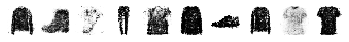

EPOCH: [40:40]   BATCH: [400:600]
	 G Loss = 0.87	 D Loss = 0.67
	 D(Real) = 0.52	 D(Fake) = 0.45


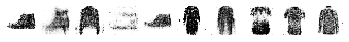

EPOCH: [40:40]   BATCH: [500:600]
	 G Loss = 0.87	 D Loss = 0.68
	 D(Real) = 0.51	 D(Fake) = 0.45


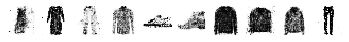

Total Training Time =  93.20170871416728 mins


In [10]:
import time
start = time.time()

# Training Constants
N_EPOCHS = 40
d_lr = 0.0002
g_lr = 0.0002
test_noise_vec = fashion_GAN.noise(5) # A fixed noise vector used for training visualisation

for epoch in range(1,N_EPOCHS+1):
    for batch, (images,labels) in enumerate(data_loader):
        g_error,d_error,avg_real_pred,avg_fake_pred = fashion_GAN.batch_train(images,d_lr,g_lr)

        # EPOCH Progress info
        if (batch) % 100 == 0:
            print("EPOCH: ["+str(epoch)+":"+str(N_EPOCHS)+"]   BATCH: ["+str(batch)+":"+str(len(data_loader))+"]")
            print("\t G Loss = "+str(np.round(g_error,2)) + "\t D Loss = "+str(np.round(d_error,2)))
            print("\t D(Real) = "+str(np.round(avg_real_pred,2)) + "\t D(Fake) = "+str(np.round(avg_fake_pred,2))) 
     
            # Display Sample Images
            sample = (fashion_GAN.generate(fashion_GAN.noise(10)).detach()).view(10,1,28,28)
            show_images(sample,10,)
            
    # Save Test Images Every EPOCH
    save_images(test_noise_vec.size(0),'./Saved Data/Fashion GAN Training Images/',epoch,test_noise_vec)
            
end = time.time()
print('Total Training Time = ',str((end - start)/60) + " mins")

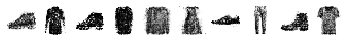

In [11]:
# Display Sample Images
sample = (fashion_GAN.generate(fashion_GAN.noise(10)).detach()).view(10,1,28,28)
show_images(sample,10,)